In [1]:
import sys
if "../src" not in sys.path:
    sys.path.append("../src")

In [2]:
import json
from tqdm.auto import tqdm
from itertools import islice
from datetime import datetime
from collections import Counter
import textwrap

import numpy as np
import pandas as pd
from gensim.models import KeyedVectors

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (accuracy_score, 
                             confusion_matrix, classification_report,
                             ConfusionMatrixDisplay)
output_paths = []

## Data dependencies

```
../data/verb_morpho.csv 15c7c1
../data/verb_morpho_emb.txt f3b2a1
../data/10.02-word-split.json 7ac81e
```

In [3]:
from hashlib import sha1
from pathlib import Path
paths = ["../data/verb_morpho.csv", 
         "../data/verb_morpho_emb.txt",
         "../data/10.02-word-split.json"]
for path_x in paths:
    h = sha1()
    h.update(Path(path_x).read_bytes())
    print(path_x, h.hexdigest()[:6])

../data/verb_morpho.csv 15c7c1
../data/verb_morpho_emb.txt f3b2a1
../data/10.02-word-split.json 7ac81e


## Load dependencies

In [4]:
mr_data = pd.read_csv("../data/verb_morpho.csv")
kv = KeyedVectors.load_word2vec_format("../data/verb_morpho_emb.txt")
with open("../data/10.02-word-split.json", "r", encoding="UTF-8") as fin:
    word_split = json.load(fin)

## Make dataset

In [5]:
mr_data.iloc[:1, ]

,Unnamed: 0,token,token_simp,source,ASBC,Apple (2006-2016),China (2015-2016),Dcard (2019-2020),PTT (2004-2019),MorphoSyntax
0,4073,丟來,丢来,Corpus,1.0,5.0,5.0,1.0,0.0,VR


In [6]:
Xtrain, ytrain, Xtest, ytest = [], [], [], []
lda_split = {"train": [], "test": []}
dropped = []
for row in mr_data.itertuples():
    word_x = row.token
    c1, c2 = list(row.token)
    if c1 in kv and c2 in kv:
        c1_vec = kv.get_vector(c1, norm=True)
        c2_vec = kv.get_vector(c2, norm=True)
        if word_x in word_split["train"]:
            Xtrain.append(np.concatenate([c1_vec, c2_vec]))        
            ytrain.append(row.MorphoSyntax)
            lda_split["train"].append(word_x)
        elif word_x in word_split["test"]:
            Xtest.append(np.concatenate([c1_vec, c2_vec]))        
            ytest.append(row.MorphoSyntax)
            lda_split["test"].append(word_x)
        else:
            print("[WARNING] word not in the split data: ", word_x)
    else:
        dropped.append((row.token, row.MorphoSyntax))
Xtrain = np.array(Xtrain)
ytrain = np.array(ytrain)
Xtest = np.array(Xtest)
ytest = np.array(ytest)
print("Train/Test words: {}/{}".format(len(lda_split["train"]), len(lda_split["test"])))

assert not (set(lda_split["train"]) & set(lda_split["test"])), "Test for data leakage"

Train/Test words: 1331/335


In [7]:
lda_split_path = "../data/tencent-mr-lda-char.split.json"
with open(lda_split_path, "w", encoding="UTF-8", newline="\n") as fout:
    json.dump(lda_split, fout)

In [8]:
## Dropped items due to no single-character word vectors
print(*textwrap.wrap(" ".join(str(x) for x in dropped)), sep="\n")

('摩醞', 'AV') ('攙入', 'VR') ('攙有', 'VR') ('決隄', 'VO') ('發訃', 'VO')
('輾去', 'VR') ('輾死', 'VR') ('輾碎', 'VR') ('顛躓', 'VV') ('餓癟', 'VR')


In [9]:
print("All instances: ", Xtrain.shape[0]+Xtest.shape[0])
print("train instances: ", Xtrain.shape[0])
print("label distribution")
print(Counter(ytrain).most_common())

All instances:  1666
train instances:  1331
label distribution
[('VR', 695), ('AV', 275), ('VV', 192), ('VO', 169)]


## Training

In [10]:
lda = LinearDiscriminantAnalysis()
lda.fit(Xtrain, ytrain)
ypred = lda.predict(Xtest)

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(Xtrain, ytrain)
ydummy = dummy.predict(Xtest)

print("Accuracy: {:.2f}".format(accuracy_score(ytest, ypred)))
print("Most-frequent baseline: {:.2f}".format(accuracy_score(ytest, ydummy)))
print("BERT accuracy (from 10.02): 0.81")
print(classification_report(ytest, ypred))

Accuracy: 0.73
Most-frequent baseline: 0.53
BERT accuracy (from 10.02): 0.81
              precision    recall  f1-score   support

          AV       0.58      0.69      0.63        64
          VO       0.64      0.69      0.67        42
          VR       0.86      0.84      0.85       178
          VV       0.54      0.41      0.47        51

    accuracy                           0.73       335
   macro avg       0.65      0.66      0.65       335
weighted avg       0.73      0.73      0.73       335



(array([0, 1, 2, 3]),
 [Text(0, 0, 'AV'), Text(0, 1, 'VO'), Text(0, 2, 'VR'), Text(0, 3, 'VV')])

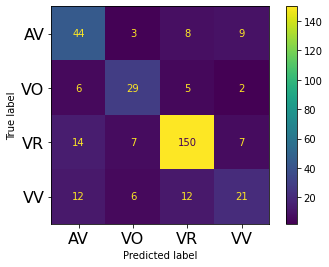

In [11]:
import matplotlib.pyplot as plt
ConfusionMatrixDisplay.from_predictions(ytest, ypred)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

## Save Model

In [12]:
import joblib
joblib.dump(lda, '../data/tencent-mr-lda-char.joblib')

['../data/tencent-mr-lda-char.joblib']

## Output Hashes

```
../data/tencent-mr-lda-char.split.json 043972
../data/tencent-mr-lda-char.joblib 28e9f7
```

In [13]:
from hashlib import sha1
from pathlib import Path
paths = [lda_split_path, '../data/tencent-mr-lda-char.joblib']
for path_x in paths:
    h = sha1()
    h.update(Path(path_x).read_bytes())
    print(path_x, h.hexdigest()[:6])

../data/tencent-mr-lda-char.split.json 043972
../data/tencent-mr-lda-char.joblib 28e9f7
